                       Topic: Adult Income Analysis and model using K-Nearest Neighbor 
                        Goal: Predict whether a person earns<=50k or >50K
                              Understand how various factor affect individual's income

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, auc

In [37]:
data=pd.read_csv('~/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
data.shape

(32561, 15)

In [3]:
(data.isna().sum()/data.shape[0])*100

age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education.num     0.0
marital.status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital.gain      0.0
capital.loss      0.0
hours.per.week    0.0
native.country    0.0
income            0.0
dtype: float64

The data showed no missing value, however upon inspection some '?' are present in some columns. Therefore, we introduced null to replace '?'. There were missing values on workclass, occupation, native.country. We handles these later. 

In [3]:
data[data=='?']=np.nan
(data.isna().sum()/data.shape[0])*100

age               0.000000
workclass         5.638647
fnlwgt            0.000000
education         0.000000
education.num     0.000000
marital.status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital.gain      0.000000
capital.loss      0.000000
hours.per.week    0.000000
native.country    1.790486
income            0.000000
dtype: float64

Mean age was 38.58, with the oldest person is 90 years old and youngest 17 years old. Maximum capital loss for the sample was 4356, least capital loss at 0 and mean loss at at 87.30. 

Half of the sample work on average 40 hours per week, 25% working 45 hours per week. Based on this observation we could guess majority are employed.


Assumption 1:
Large number from the sample are employed, therefore, working hours could be an important factor in predicting one's income.

In [13]:
data.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Visualizing continous variables:
1) Age 
The age variable is skewed to the left with large proportion in the 40-45 age bracket. General knowledge dictate, often than not salary increase as age increases. This could be a good predictor of income. 
    

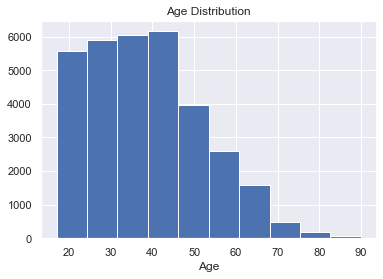

In [3]:
sns.set_theme(style='darkgrid')
data.age.hist()
plt.xlabel('Age')
plt.title('Age Distribution')
plt.show()

2. Check how working hours is distributed in population. 
We confirm our assumption 1, majority work 40 hours per week. Followed by those working 60 hours per week. 

Assumption 2:
The more hours spent at work , the higher the income. If statisticaly verified, this could be an important feature for modeling income. 

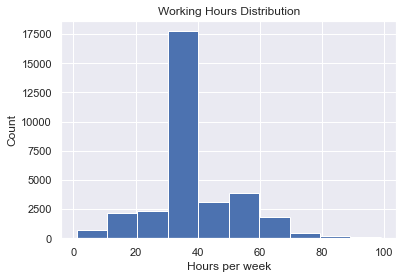

In [34]:
data['hours.per.week'].hist()
plt.title('Working Hours Distribution')
plt.xlabel('Hours per week')
plt.ylabel('Count')
plt.show()

3. Education years 
Visualize how years spent on education is disributed. We could guess/draw an assumption that the more years spent on studies the higher the income. There is neeed to verify if this is statisticaly correct, if so, we include this variable in our model. Largest proportion spent 10 years in education. 

Assumption 3: Education years and income are correlated. 


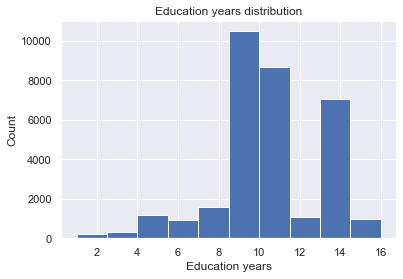

In [6]:
data['education.num'].hist()
plt.xlabel('Education years')
plt.title('Education years distribution')
plt.ylabel('Count')
plt.show()

Visualizing Categorical variables and continous variables to verify our assumptions.

4. Age versus income
convert age to a categorical variable by binning age. This verifies our assumption 1:
People in 16-24 age bracket majority earn <=50k. 
The number of people earning >50k increases with age and shows a declining trend after 65 years. People in the 65+ are less productive due to old age and diseases that with old age, we can guess those earning >50k from this age group have capital gains(accrued from investments). Therefore, age is a perfect predictor for our income model.

Assumption 4: capital gains increase with age. 

In [4]:
grps=[16, 25,35,45,65,100]
label=['16-24','25-34','35-44','45-64','65+']
data['Age_grp']=pd.cut(data['age'],bins=grps, labels=label)

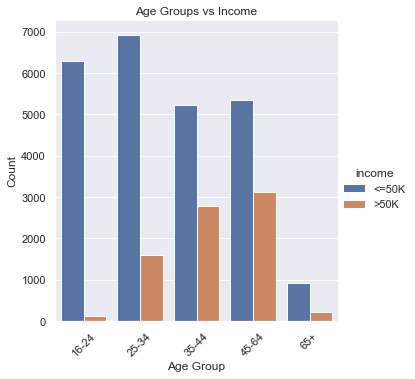

In [9]:
sns.catplot(x='Age_grp', hue='income',kind='count', data=data)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Age Groups vs Income')
plt.show()

5. WORKING HOURS PER WEEEK vs INCOME 
As the number of working hours increases the gap between those earning >50 and less decreases. This implies hours affect income. Thus satistifying assumption 2 and concluding hours is a good predictor of income.

In [5]:
grps=[0, 20,40,60,80,100]
label=['0-19','20-39','40-59','60-79','80+']
data['work_hours']=pd.cut(data['hours.per.week'],bins=grps, labels=label)

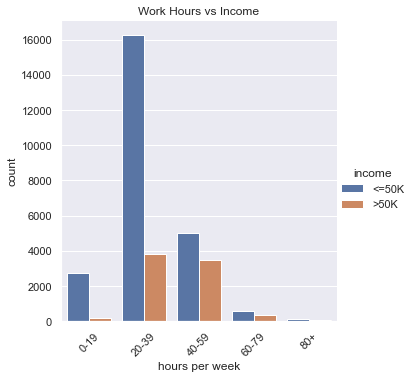

In [11]:
sns.catplot(x='work_hours', hue='income',kind='count',data=data)
plt.title('Work Hours vs Income')
plt.xlabel('hours per week')
plt.xticks(rotation=45)
plt.show()

3. EDUCATION YEARS VERSUS INCOME 
How does income relate to years spent in school ?
create 3 categories/levels for years in school: This was derived from observation between education level and number of years in school and calculating the mean number of years spent to attain each education level. 

Basic: spent 1-9 years comprising from 10th grade to other lower levels  
Tertiary: spent spent 10-12 years accomodating college and undergraguates 
Specialized: spent 13-16 years in school. This comprises masters, doctorate, prof etc

3.a. It's clear education level and years spent in education are good predictors of income. More people who spent 1-9 years in school(basic) earn <=50k and very few earning >50k in this category.
3.b. Largest sample with specialized education(=>13yrs in school) earn >50k.

This verified assumption 3, we include grouped education_years in our model.

In [58]:
f=data[['education','work_hours','education.num']]
f.groupby('education')['education.num'].mean()

education
10th             6.0
11th             7.0
12th             8.0
1st-4th          2.0
5th-6th          3.0
7th-8th          4.0
9th              5.0
Assoc-acdm      12.0
Assoc-voc       11.0
Bachelors       13.0
Doctorate       16.0
HS-grad          9.0
Masters         14.0
Preschool        1.0
Prof-school     15.0
Some-college    10.0
Name: education.num, dtype: float64

In [6]:
grps=[0,10,14,16]
labs=['Basic', 'Tertiary','Specialized']
data['edu_grps']=pd.cut(data['education.num'], bins=grps,labels=labs)

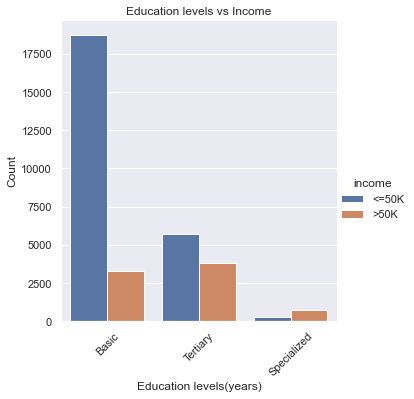

In [13]:
sns.catplot(x='edu_grps', hue='income',kind='count', data=data)
plt.xlabel('Education levels(years)')
plt.ylabel('Count')
plt.title('Education levels vs Income')
plt.xticks(rotation=45)
plt.show()


VISUALIZE CATEGORICAL VARIABLES AND INCOME

1. Gender versus Income 
In the female category very few earn >50. This shows there is positive correlation between gender and income. Male has a higher positive correlation to earning >50k compared to their counterparts. Consequently we select gender as a predictor of income. 


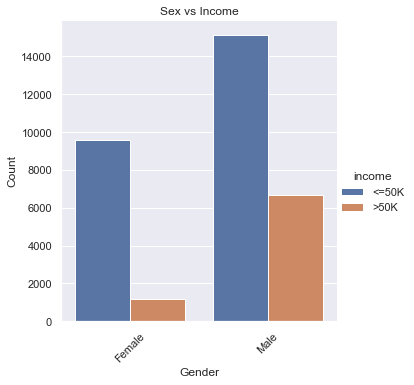

In [14]:
sns.catplot(x='sex', hue='income',kind='count', data=data)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Sex vs Income')
plt.xticks(rotation=45)
plt.show()

In [7]:

data['income_2']=data['income'].map({'<=50K':0, '>50K':1})
k=data[['sex','income_2']]
k.groupby(['sex'], as_index=False).mean().sort_values(by='income_2', ascending=True)

,sex,income_2
0,Female,0.109461
1,Male,0.305737


Lets check correlation between grouped working hrs and income. There is a positive correlation between work hours and income. Working 40-59 hours had highest positive correlation. This confirms that work_hours is a good predictor.


In [9]:
data[['income_2', 'work_hours']].groupby('work_hours', as_index=False).mean().sort_values(by='income_2', ascending=True)

,work_hours,income_2
0,0-19,0.066598
1,20-39,0.189009
4,80+,0.302885
3,60-79,0.378049
2,40-59,0.407508


RACE VERSUS INCOME 
Asian-Pac-Islander, Other and Amer-Indian-Eskimo each represent a small proportion in the sample so we can put them in one category called Other. Whites had highest positive correlation to earning >50k followed by Other. Black had least chance earning <=50k.Thus, race is a good predictor of income. 

In [8]:
dict={'White':'White','Black':'Black','Asian-Pac-Islander':'Other','Other':'Other', 'Amer-Indian-Eskimo':'Other'}
data['race']=data['race'].map(dict)

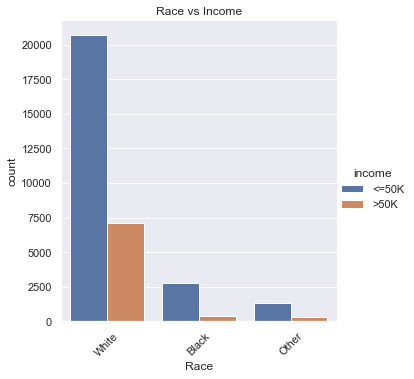

In [16]:
sns.catplot(x='race',hue='income',kind='count',data=data)
plt.xticks(rotation=45)
plt.xlabel('Race')
plt.title('Race vs Income')
plt.show()

In [11]:
data[['race','income_2']].groupby('race',as_index=False).mean()

,race,income_2
0,Black,0.123880
1,Other,0.207896
2,White,0.255860


WORKCLASS VERSUS INCOME 
It is evident there is strong correlation or relationship between workclass and income. Self-employed-inc persons had highest chance earning >50k with correlation >0.5. We include this in our model.


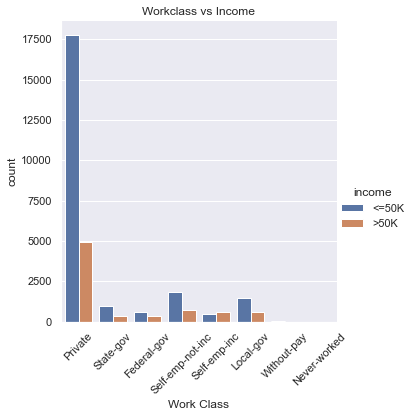

In [20]:
sns.catplot(x='workclass', hue='income',data=data, kind='count')
plt.xticks(rotation=45)
plt.title('Workclass vs Income')
plt.xlabel('Work Class')
plt.show()

In [9]:
data[['workclass','income_2']].groupby('workclass',as_index=False).mean().sort_values(by='income_2',ascending=True)

,workclass,income_2
2,Never-worked,0.000000
7,Without-pay,0.000000
3,Private,0.218673
6,State-gov,0.271957
5,Self-emp-not-inc,0.284927
1,Local-gov,0.294792
0,Federal-gov,0.386458
4,Self-emp-inc,0.557348


In [23]:
data.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

7. MARITAL STATUS VERSUS INCOME 
Never-married persons had the least chance earning >50k, while maried-civ-spouse had highest chance earning >50k. This is an important variable to our solution goal.


In [13]:
data[['marital.status','income_2']].groupby('marital.status',as_index=False).mean().sort_values(by='income_2',ascending=True)

,marital.status,income_2
4,Never-married,0.045961
5,Separated,0.064390
3,Married-spouse-absent,0.081340
6,Widowed,0.085599
0,Divorced,0.104209
1,Married-AF-spouse,0.434783
2,Married-civ-spouse,0.446848


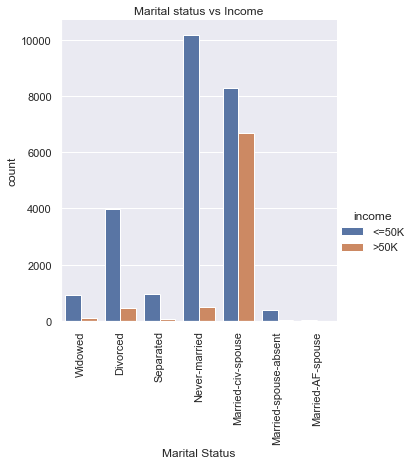

In [26]:
sns.catplot(x='marital.status', hue='income', kind='count',data=data)
plt.xticks(rotation=90)
plt.title('Marital status vs Income')
plt.xlabel('Marital Status')
plt.show()

                        7. DATA PREPARATION FOR MODELING 
1. Fill missing values
2. Rename some categories 
3. Transform categories to numerical data

Selected indipendent variables for modelling:
Age_grps, sex, work_hours, edu_grps, race, workclass,occupation, marital.status, net_capital, 

In [14]:
#marital status 
data.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
Age_grp              0
work_hours           0
edu_grps             0
income_2             0
dtype: int64

In [10]:
#missing values corrected
data['workclass'].fillna(data['workclass'].mode()[0], inplace=True)
data['occupation'].fillna(data['occupation'].mode()[0], inplace=True)

In [11]:
#feature engineering for ordinal categories 
data.work_hours=data['work_hours'].map({'0-19':0,'20-39':1,'40-59':2,'60-79':3,'80+':4})
data.Age_grp=data['Age_grp'].map({'16-24':0,'25-34':1,'35-44':2,'45-64':3, '65+':4})
data.edu_grps=data['edu_grps'].map({'Basic':0, 'Tertiary':1, 'Specialized':2})

#get dummies for nominal categorical variables 
columns=['workclass','marital.status','race','sex', 'occupation']
new_data=pd.get_dummies(data[columns])


In [12]:
new_data['net.capital']=data['capital.gain']-data['capital.loss']
new_data['Age_grp']=data['Age_grp']
new_data['work_hours']=data['work_hours']
new_data['edu_grps']=data['edu_grps']

In [13]:
print(new_data.shape)
print(data.shape)

(32561, 38)
(32561, 19)


In [56]:
new_data.head()

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital.status_Divorced,marital.status_Married-AF-spouse,...,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,net.capital,Age_grp,work_hours,edu_grps,income
0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,-4356,4,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,-4356,4,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,-4356,4,1,0,0
3,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,-3900,3,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,-3900,2,1,0,0


In [16]:
x=new_data.drop('income',axis=1)
y=new_data['income']
scaler=StandardScaler()
x=scaler.fit_transform(x)

split data into test and train sets. Here we reshufle the data to ensure balanced classes of indipendent variable to avoid bias in our model. The data is split in 70:30 ration , test set is 30% original dataset while train take 70%. 

In [18]:
x_train, x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

In [19]:
def val_score(n_neighbors):
    avg=[]
    std=[]
    for i in n_neighbors:
        score=cross_val_score(KNN(n_neighbors=i),x_train,y_train, cv=10)
        avg.append(score.mean())
        std.append(score.std())
    return avg, std

In [62]:
##k-nn model

n_neighbors=range(1,30)
avg, std=val_score(n_neighbors)

In [63]:
avg

[0.7854077080590902,
 0.8094946036658122,
 0.8100653372131512,
 0.8199366642802707,
 0.8228760690669192,
 0.8255082446132883,
 0.8261227608292343,
 0.8272635928346534,
 0.8257720760875422,
 0.8284046557816216,
 0.8296331685950286,
 0.8305105155385173,
 0.8303350192066388,
 0.8307737311686413,
 0.831036889063378,
 0.8312123084147401,
 0.8298521011831905,
 0.8316947260648331,
 0.83244076349276,
 0.8324407057573728,
 0.8317826763046273,
 0.8324847771029151,
 0.8332744432384164,
 0.8325285790166509,
 0.832703998368013,
 0.8322654596121721,
 0.8322217539240819,
 0.8316953611540919,
 0.8318269978368475]

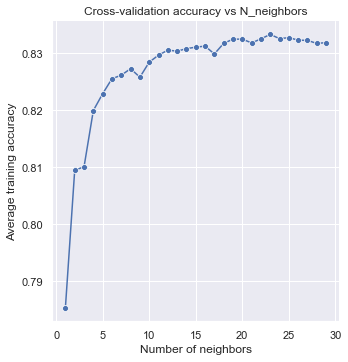

In [64]:
sns.set_theme(style='darkgrid')
sns.relplot(x=n_neighbors, y=avg, kind='line',color='b', marker='o')
plt.xlabel('Number of neighbors')
plt.ylabel('Average training accuracy')
plt.title('Cross-validation accuracy vs N_neighbors')
plt.show()

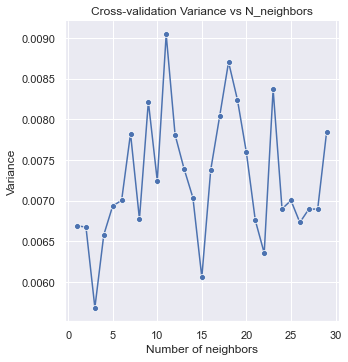

In [66]:
sns.relplot(x=n_neighbors, y=std, kind='line',color='b', marker='o')
plt.xlabel('Number of neighbors')
plt.ylabel('Variance')
plt.title('Cross-validation Variance vs N_neighbors')
plt.show()

In [28]:
model=KNN(n_neighbors=3, leaf_size=300,algorithm='kd_tree')
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=300, n_neighbors=3)

In [29]:
y_pred=model.predict(x_test)

In [32]:
accuracy_score(y_test, y_pred)

0.8141058450199611

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score

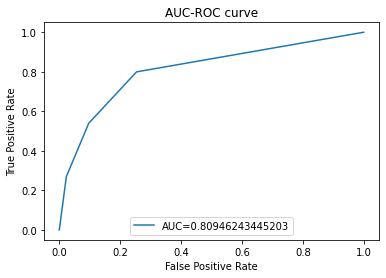

In [55]:
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('AUC-ROC curve')
plt.legend(loc=8)
plt.show()